In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn 
import time

In [3]:
#from tensorflow.keras import models
#from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [5]:
df_input = pd.read_csv("CD3D_100-150℃_0.2-1.6mm_0.4-0.9V_std", usecols=[1,2,3,4,5] )#col[6]:W_chをdrop

In [6]:
df_output = pd. read_csv("CD3D_100-150℃_0.2-1.6mm_0.4-0.9V", usecols=[7])

In [7]:
df_input.shape #0.45V20℃1.5ms1.6mmと0.65V130℃1.5ms1.6mmのデータなし

(5880000, 5)

In [8]:
df_output.shape

(5880000, 1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.1, random_state=0)

In [10]:
print(x_train.shape,x_test.shape)

(5292000, 5) (588000, 5)


In [11]:
x_train

,x座標,y座標,z座標,V[V],T_cell[℃]
5471191,0.306461,0.706739,-0.636484,1.257201,1.453669
2868884,0.055646,-1.646762,-0.913934,0.941289,-0.297883
5733272,-0.153366,-1.262536,-1.155252,0.625377,1.453669
200929,-0.274593,0.738098,1.150813,0.625377,-1.465584
90277,-0.926713,-0.216606,1.557310,-0.954184,-1.465584
...,...,...,...,...,...
2249467,-1.194249,0.031731,1.020476,0.941289,-0.297883
5157699,-0.291314,-0.663866,1.666999,1.257201,1.453669
2215104,-1.127365,1.268348,1.408906,1.257201,-0.297883
1484405,-0.320576,-0.316384,0.073273,-0.322359,-0.881734


In [12]:
y_train

,i[A/m^2]
5471191,3258.260193
2868884,1838.461275
5733272,4839.370980
200929,2443.410761
90277,14124.447796
...,...
2249467,2682.287846
5157699,3674.578790
2215104,1330.409154
1484405,8191.613778


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import regularizers, initializers

model = Sequential()

weights = [com.get_weights() for com in model.layers[0:]]  #重さを抽出（※始めに回すときだけ下の行と入れ替える）



model.add(Dense(units=32, input_shape=(5,), activation='relu'))  
model.add(Dense(units=10, activation='relu'))  #
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1, activation='linear'))  #隠れ層3層でやってみる

model.compile(loss='mean_absolute_error',    
              optimizer='adam',             #とりあえずadamで
              metrics=['mae'],
              run_eagerly=False)   #計算時間5倍くらいかかる

In [14]:
start_time = time.time()
callbacks1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae',
                            factor=0.2,
                            patience=5,
                            mode="auto",
                            min_lr=0.001) #最初は0.001だった
callbacks2 = tf.keras.callbacks.EarlyStopping(monitor="val_mae",
                                              patience=5, #20→5
                                              mode="auto")
history =  model.fit(x=x_train,
                     y=y_train,
                     epochs = 20000,
                     batch_size=200,
                     validation_data=(x_test, y_test),
                     callbacks=[callbacks1,callbacks2])
end_time = time.time()
elapsed_time = end_time - start_time   #経過時間を計算して表示
print(f"計算にかかった時間: {elapsed_time}秒")

Epoch 1/20000
26460/26460 [==============================] - 102s 4ms/step - loss: 1073.9500 - mae: 1073.9500 - val_loss: 575.0779 - val_mae: 575.0779 - lr: 0.0010
Epoch 2/20000
26460/26460 [==============================] - 116s 4ms/step - loss: 465.9876 - mae: 465.9876 - val_loss: 407.8036 - val_mae: 407.8036 - lr: 0.0010
Epoch 3/20000
26460/26460 [==============================] - 102s 4ms/step - loss: 378.3651 - mae: 378.3651 - val_loss: 358.2047 - val_mae: 358.2047 - lr: 0.0010
Epoch 4/20000
26460/26460 [==============================] - 89s 3ms/step - loss: 350.7094 - mae: 350.7094 - val_loss: 343.9042 - val_mae: 343.9042 - lr: 0.0010
Epoch 5/20000
26460/26460 [==============================] - 84s 3ms/step - loss: 339.0235 - mae: 339.0235 - val_loss: 331.2126 - val_mae: 331.2126 - lr: 0.0010
Epoch 6/20000
26460/26460 [==============================] - 79s 3ms/step - loss: 325.3401 - mae: 325.3401 - val_loss: 319.4379 - val_mae: 319.4379 - lr: 0.0010
Epoch 7/20000
26460/26460 [==

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])

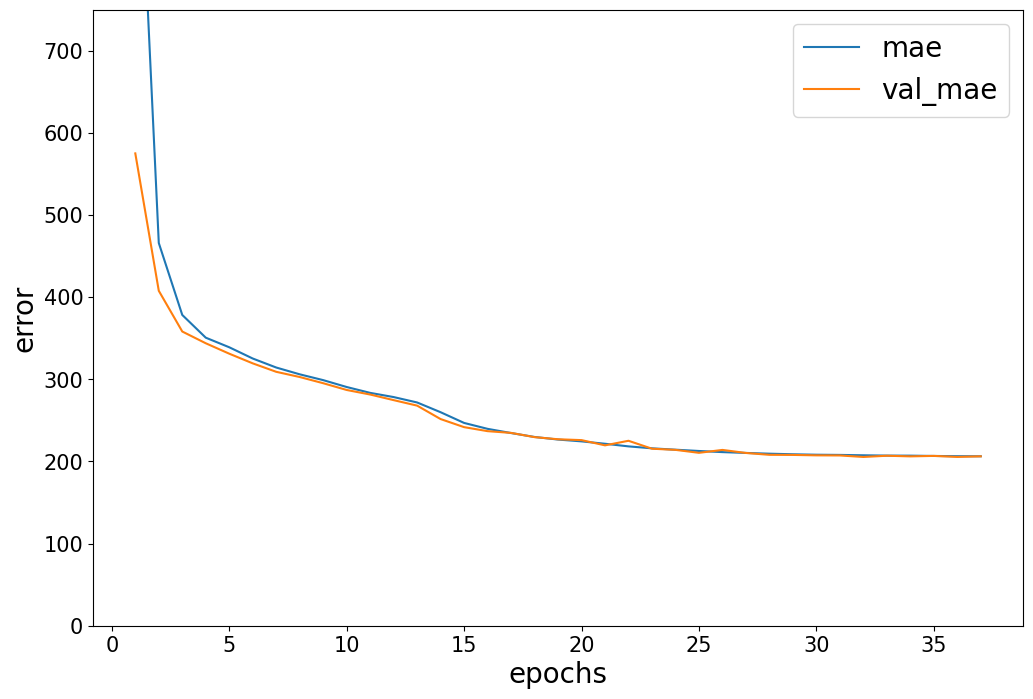

In [19]:
mae = history_dict['mae']
val_mse = history_dict['val_mae']
epochs = range(1, len(mae) + 1)

plt.rcParams["font.size"] = 15
plt.figure(figsize=(12, 8))
plt.plot(epochs, mae, label='mae')
plt.plot(epochs, val_mse, label='val_mae')
plt.xlabel("epochs",fontsize=20)
plt.ylabel("error",fontsize=20)
plt.ylim((0,750))
plt.legend(loc = 'best',fontsize=20)
#plt.savefig('mae_transition.png')
plt.show()

In [20]:
weights = [com.get_weights() for com in model.layers[0:]] 
model.layers[0].set_weights(weights[0])
model.layers[1].set_weights(weights[1])
model.layers[2].set_weights(weights[2])

In [21]:
model.save('i_predict CD_3Ddist_drop-column')

INFO:tensorflow:Assets written to: i_predict CD_3Ddist_drop-column\assets


In [21]:
import shap

c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# SHAPの準備
explainer = shap.Explainer(model, x_train)

# SHAP値の計算
shap_values = explainer(x_train)

# SHAP値をプロットする
shap.summary_plot(shap_values, x_train)

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence
# 部分依存プロットを計算する
# feature_idxは目的の特徴量のインデックス、ここでは 0 と仮定しています
# もし複数の特徴量を調べたい場合は、feature_idx=[0, 1, ...] のようにインデックスを指定します
partial_dependence(model, x_train, features=['x座標','y座標','z座標','V[V]','T_cell[℃]','W_ch[mm]'])


MemoryError: Unable to allocate 1.48 GiB for an array with shape (198000000,) and data type float64